# Part2

## Load libraries, data, and functions for compression classification 

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# import gzip classifier -> install by 'pip install npc-gzip'
from npc_gzip.compressors.base import BaseCompressor
from npc_gzip.compressors.gzip_compressor import GZipCompressor
from npc_gzip.knn_classifier import KnnClassifier
# for plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
# Function to efficiently load and pre-process data with sample size reduction
def pass_data():
    df = pd.read_csv("train_40k.csv", encoding="latin-1")

    # Reduce sample size if needed
    sample_size=5000
    
    if len(df) > sample_size:
        df = df.sample(n=sample_size, random_state=42)

    df["text"] = df["Text"]
    df["label"] = df["Cat1"]
    return df

def get_data(test_size=0.2):
    df = pass_data()
    X_train, X_test, y_train, y_test = train_test_split(
        df["text"], df["label"], test_size=test_size, random_state=42
    )
    # Encode labels
    label_encoder = LabelEncoder()
    train_text = X_train.to_numpy()
    train_labels = label_encoder.fit_transform(y_train.to_numpy())
    test_text = X_test.to_numpy()
    test_labels = label_encoder.fit_transform(y_test.to_numpy())
    return (train_text, train_labels), (test_text, test_labels)



In [3]:
def fit_predict(
    train_text, train_labels, test_text, test_labels, distance_metric, k
):
    compressor = GZipCompressor()
    model = KnnClassifier(
        compressor=compressor,
        training_inputs=train_text,
        training_labels=train_labels,
        distance_metric=distance_metric,
    )
    predictions, labels, _ = model.predict(test_text, k)
    accuracy = classification_report(test_labels, labels.reshape(-1), output_dict=True, zero_division=0)['accuracy']
    return accuracy


In [4]:
# Define k values to evaluate
k_values = np.arange(1, 21)

# Define distance metrics in npc-gzip
distance_metrics = ['ncd', 'clm', 'cdm', 'mse']

# Initialize dictionary to store results
results = {metric: {} for metric in distance_metrics}

# Load data
(train_text, train_labels), (test_text, test_labels) = get_data()

See the characterization of train set

In [5]:
print("The average number of characters in training text is: ", np.mean([len(text) for text in train_text]))
print("The average number of words in training text is: ", np.mean([len(text.split()) for text in train_text]))
print("The number of unique labels is: ", len(np.unique(train_labels)))

The average number of characters in training text is:  431.73225
The average number of words in training text is:  81.6655
The number of unique labels is:  6


Train compression methods 

In [6]:
# Iterate through distance metrics and k values
for metric in distance_metrics:
    for k in k_values:
        results[metric][k] = fit_predict(train_text, train_labels, test_text, test_labels, metric, k)

Compressing input...: 100%|██████████| 1000/1000 [02:02<00:00,  8.19it/s]


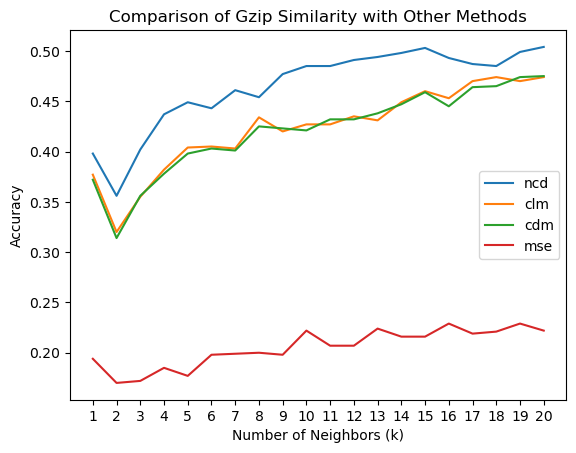

In [7]:
# Plot accuracy vs k for each method
for metric, data in results.items():
    sns.lineplot(x = list(data.keys()), y = list(data.values()), label=metric)

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("Comparison of Gzip Similarity with Other Methods")
plt.legend()
plt.show()

In [8]:
max_accuracy_gzip = max(results['ncd'].values())
print("The maximum accuracy for Gzip similarity is: ", max_accuracy_gzip)

The maximum accuracy for Gzip similarity is:  0.504


## Default KNN and SVM in Sklearn

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# vectorize text
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_text)
X_test = vectorizer.transform(test_text)

standard_knn_results = {}

for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, train_labels)
    predictions = knn_model.predict(X_test)
    accuracy = classification_report(test_labels, predictions, output_dict=True, zero_division=0)['accuracy']
    standard_knn_results[k] = accuracy

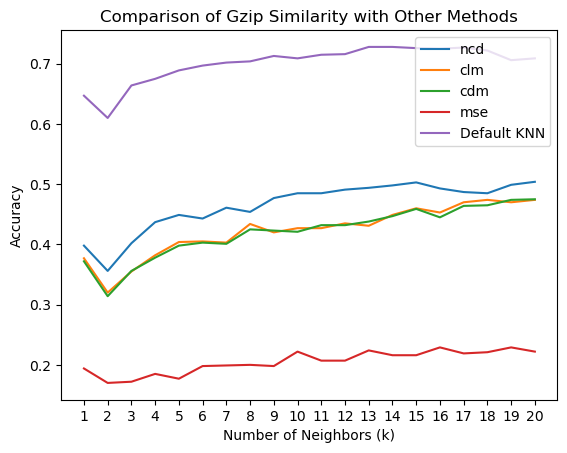

In [10]:
for metric, data in results.items():
    sns.lineplot(x = list(data.keys()), y = list(data.values()), label=metric)

sns.lineplot(x = list(standard_knn_results.keys()), y = list(standard_knn_results.values()), label="Default KNN")

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("Comparison of Gzip Similarity with Other Methods")
plt.legend()
plt.show()

In [11]:
max_default_knn_accuracy = max(standard_knn_results.values())
print("The maximum accuracy for default KNN is: ", max_default_knn_accuracy)

The maximum accuracy for default KNN is:  0.728


In [12]:
from sklearn.svm import SVC

model = SVC(kernel="linear")  # Choose the desired kernel function
model.fit(X_train, train_labels)

# Predict labels for the test data
predictions = model.predict(X_test)

# Evaluate the model using classification report
report = classification_report(test_labels, predictions, output_dict=True, zero_division=0)

svm_accuracy = report['accuracy']
print("The accuracy of the SVM model is: ", svm_accuracy)


The accuracy of the SVM model is:  0.794


In [32]:
df_result = pd.DataFrame({'Method': ['Gzip Similarity', 'Default KNN', 'SVM'], 'Accuracy': [max_accuracy_gzip, max_default_knn_accuracy, svm_accuracy]})
print(df_result)

            Method  Accuracy
0  Gzip Similarity     0.504
1      Default KNN     0.728
2              SVM     0.794
